<a href="https://colab.research.google.com/github/adelelwan24/Prediction-of-Obesity-Risk/blob/adel/preprocessing-adel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1- Data Loading

In [1]:
%%capture
!pip install xgboost
!pip install lightbm
!pip install catboost
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier, VotingClassifier

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

| Abbreviation   | Full Form                                 |
|:---------------|:------------------------------------------|
| FAVC           | Frequent consumption of high caloric food |
| FCVC           | Frequency of consumption of vegetables    |
| NCP            | Number of main meals                      |
| CAEC           | Consumption of food between meals         |
| CH20           | Consumption of water daily                |
| CALC           | Consumption of alcohol                    |
| SCC            | Calories consumption monitoring           |
| FAF            | Physical activity frequency               |
| TUE            | Time using technology devices             |
| MTRANS         | Transportation used                       |

| Column | Full Form | Description|
|---|---|---|
| id| id | Unique for each person(row)|
|Gender| Gender| person's Gender|
| Age | Age| Dtype is float. Age is between 14 years to 61 years |
|Height| Height | Height is in meter it's between 1.45m to 1.98m|
| Weight | Weight| Weight is between 39 to 165. I think it's in KG.|
|family_history_with_overweight'| family history <br> with overweight| yes or no question|
| FAVC| Frequent consumption <br> of high calorie food| it's yes or no question. i think question they asked is <br>do you consume high calorie food|
|FCVC|  Frequency of <br>consumption of vegetables| Similar to FAVC. this is also yes or no question|
|NCP| Number of main meals| dtype is float, NCP is between 1 & 4. I think it should be 1,2,3,4 <br>but our data is synthetic so it's taking float values|
|CAEC| Consumption of <br>food between meals| takes 4 values Sometimes, Frequently, no & Always <br>|
| SMOKE| Smoke | yes or no question. i think the question is "Do you smoke?" |
|CH2O| Consumption of <br>water daily| CH2O takes values between 1 & 3. again it's given as <br>float may be because of synthetic data. it's values should be 1,2 or 3|
|SCC|  Calories consumption <br>monitoring| yes or no question|
|FAF| Physical activity <br>frequency| FAF is between 0 to 3, 0 means no physical activity<br> and 3 means high workout. and again, in our data it's given as float|
|TUE| Time using <br>technology devices| TUE is between 0 to 2. I think question will be "How long you have <br>been using technology devices to track your health." in our data it's given as float |
|CALC| Consumption of alcohol | Takes 3 values: Sometimes, no, Frequently|
| MTRANS | Transportation used| MTRANS takes 5 values Public_Transportation, Automobile, <br>Walking, Motorbike, & Bike|
|NObeyesdad| TARGET | This is our target, takes 7 values, and in this comp. we have to give <br>the class name (Not the Probability, which is the case in most comp.

In [3]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.shape, df_test.shape

((20758, 18), (13840, 17))

## 🚁 Supporting Functions

In [4]:
def HeatmapPlot(df, figsize=(10, 10), threshold=0):
    plt.figure(figsize=figsize)

    mask = ~(np.tril(np.ones_like(df, dtype=bool)) & (abs(df) > threshold))

    sns.heatmap(df, annot=True, fmt='.2f', linewidths=1,
                linecolor='k', vmin=-1, vmax=1,mask=mask,
                square=True, cmap='RdBu', center=0, cbar_kws={'shrink' : .5})

In [5]:
def PlotBoxs(df, cols, ncols=1,figsize=(20, 5)):

    # plt.figure(figsize=figsize)
    nrows = len(cols) // ncols
    fig, ax = plt.subplots(nrows, ncols)
    fig.set_size_inches(figsize)
    ax = ax.flatten()
    for i, col in enumerate(cols):
        sns.boxplot(df, x=col, ax=ax[i])
        # plt.title(col.replace("_", " ").title())
    plt.tight_layout(pad=1)

In [6]:
def TSNE_2D_VIS(df, hue=None, title='T-SNE', p='CMRmap'):
    assert df.shape[1] == 2, "The 2nd Dimention should 2!!"
    sns.scatterplot(x = df[:, 0], y = df[:, 1], alpha=.7,
                    hue=hue, edgecolor='gray', palette=p)
    plt.title(title);

def TSNE_2D(df, perplexity=30, n_iter=500, init='pca', lr='auto',
            verbose=0, hue=None, title="Projection on 2D (T-SNE)"):
    tsne = TSNE(n_components=2, perplexity=perplexity,
                n_iter=n_iter, learning_rate=lr, init=init, verbose=verbose, n_jobs=-1)
    df_2d = tsne.fit_transform(df)

    TSNE_2D_VIS(df_2d, hue=hue, title=title)

    return df_2d

In [7]:
def ExplainedVarPlot(df, dataset_title='Original', ratio=False):
    test = PCA()

    if ratio:
        explained_var = test.fit(df).explained_variance_ratio_
        plt.ylabel('Explained Variance Ratio')
    else:
        explained_var = test.fit(df).explained_variance_
        plt.ylabel('Explained Variance')

    sns.barplot(explained_var)
    plt.xticks(ticks=range(test.n_features_in_), labels=test.feature_names_in_, rotation=90)
    plt.xlabel('Features')
    plt.title(dataset_title);
    # plt.title(f"Explained Variace on {dataset_title}");

## 2- Data Investigation

In [8]:
df.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [9]:
df.sample(7)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
9673,9673,Male,23.000000,1.700000,53.000000,yes,yes,2.000000,3.000000,Sometimes,yes,2.000000,no,3.0000,1.000000,Sometimes,Public_Transportation,Normal_Weight
8120,8120,Female,26.000000,1.632983,111.157811,yes,yes,3.000000,3.000000,Sometimes,no,2.638896,no,0.0000,0.445495,Sometimes,Public_Transportation,Obesity_Type_III
3893,3893,Female,43.376340,1.582523,81.919454,yes,yes,2.008760,1.217651,Sometimes,no,2.559750,no,0.0000,0.000000,no,Automobile,Overweight_Level_I
267,267,Male,26.680376,1.764140,118.436166,yes,yes,2.239634,3.000000,Sometimes,no,2.224164,no,0.8554,0.000000,Sometimes,Public_Transportation,Obesity_Type_II
4194,4194,Female,21.000000,1.500000,48.000000,yes,yes,2.000000,3.000000,Sometimes,no,1.000000,no,2.0000,0.000000,Sometimes,Public_Transportation,Normal_Weight
418,418,Male,24.000000,1.600000,56.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,0.0000,0.000000,Sometimes,Public_Transportation,Normal_Weight
1568,1568,Male,18.000000,1.650000,93.000000,yes,yes,2.000000,3.000000,Sometimes,no,2.000000,no,0.0000,1.000000,no,Public_Transportation,Obesity_Type_I


In [10]:
df.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


### Data Types

Required datatypes convertions:
- Age -> integer
- FCVC -> Flaot
- NCP -> Float
- CH2O -> Float
- FAF -> Float
- Tue -> Float

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

### Nulls & Duplicates

In [12]:
df.isna().sum().sum()

0

In [13]:
df.duplicated().sum()

0

## 3- Exploratory Data Analysis

In [14]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [15]:
# plt.style.use('bmh')
sns.set_style('darkgrid')
# sns.set_palette("Dark2")
sns.set_palette("CMRmap")

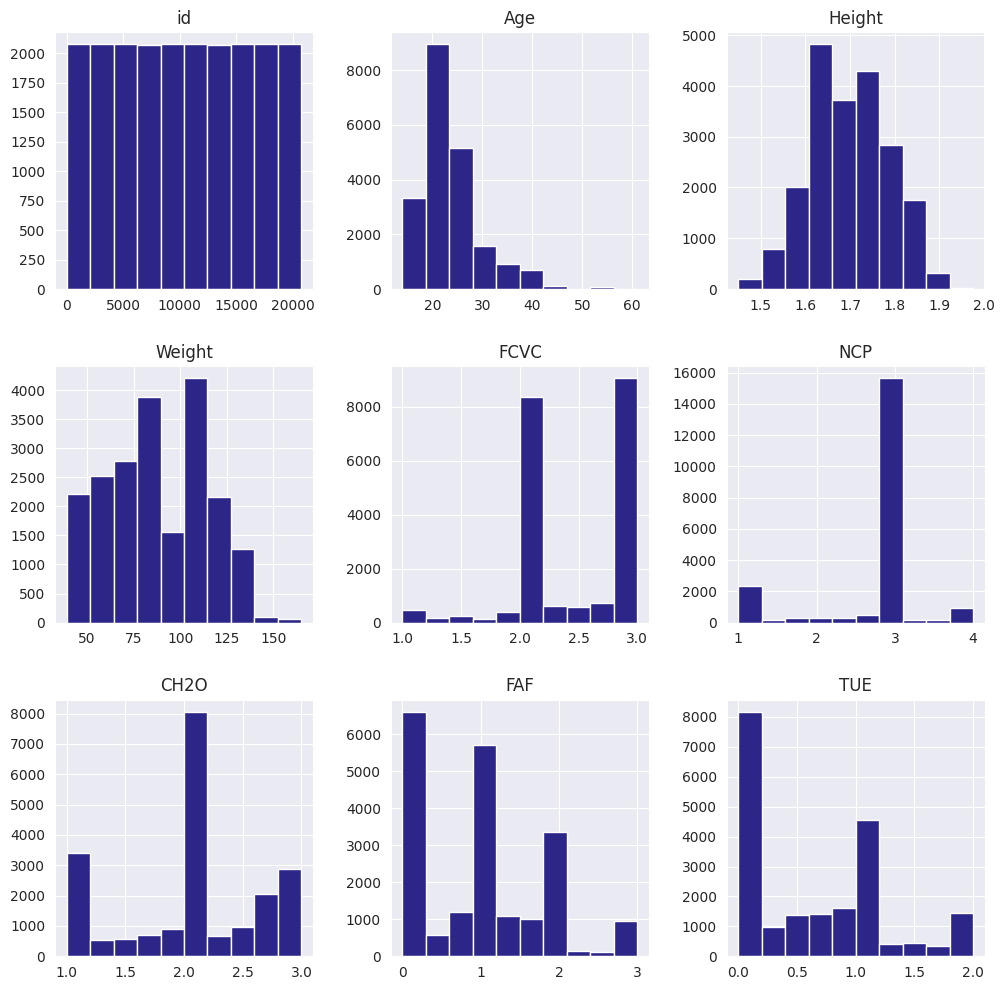

In [16]:
df.hist(figsize=(12, 12));

In [17]:
df.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

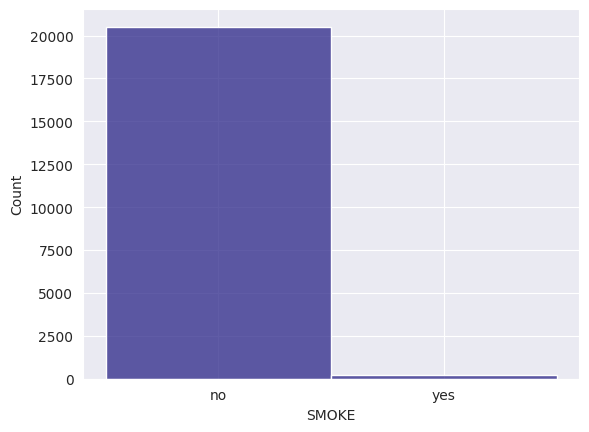

In [18]:
sns.histplot(df, x='SMOKE');

<Axes: xlabel='Count', ylabel='NObeyesdad'>

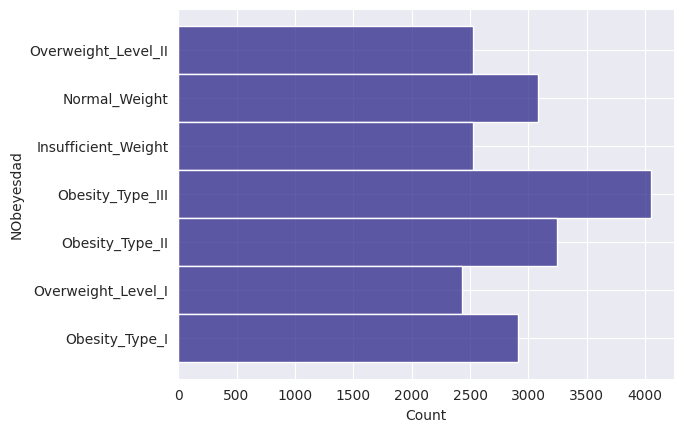

In [19]:
sns.histplot(df, y='NObeyesdad')

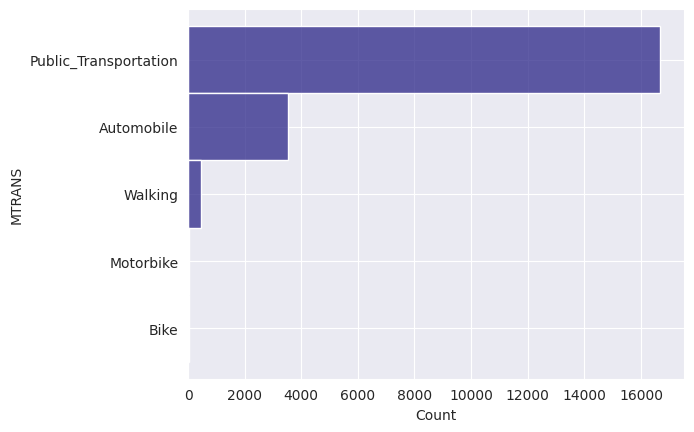

In [20]:
sns.histplot(df, y='MTRANS');

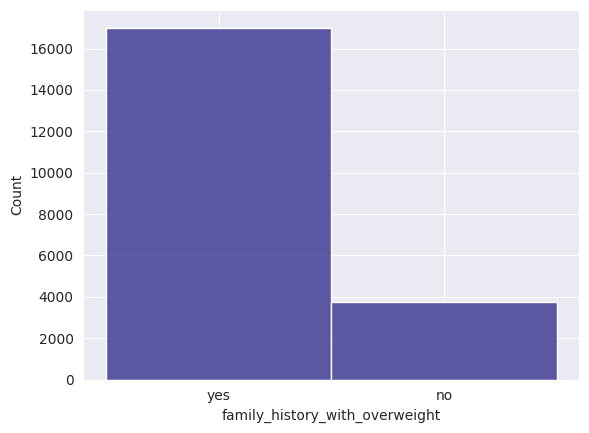

In [21]:
sns.histplot(df, x='family_history_with_overweight');

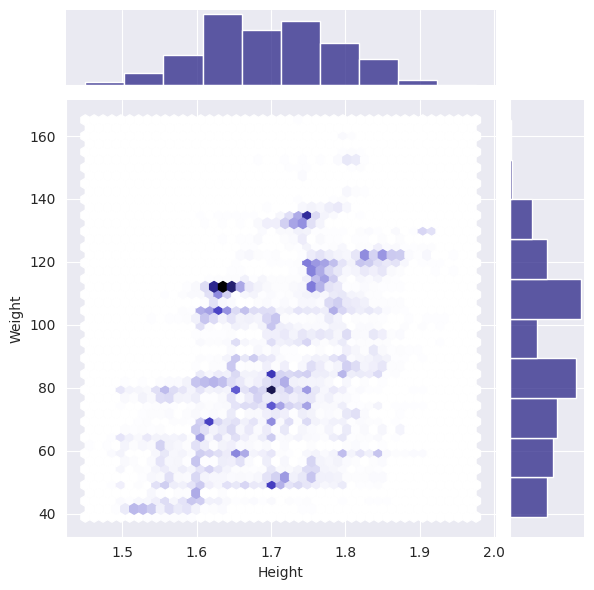

In [22]:
sns.jointplot(df, x='Height', y='Weight', kind='hex', marginal_kws=dict(bins=10, fill=True))

In [35]:
np.tril(np.ones_like(df, dtype=bool))

array([[ True, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [33]:
def HeatmapPlot(df, figsize=(10, 10), threshold=0):
    plt.figure(figsize=figsize)

    mask = ~(np.tril(np.ones_like(df, dtype=bool)) & (abs(df) > threshold))

    sns.heatmap(df, annot=True, fmt='.2f', linewidths=1,
                linecolor='k', vmin=-1, vmax=1,mask=mask,
                square=True, cmap='RdBu', center=0, cbar_kws={'shrink' : .5})

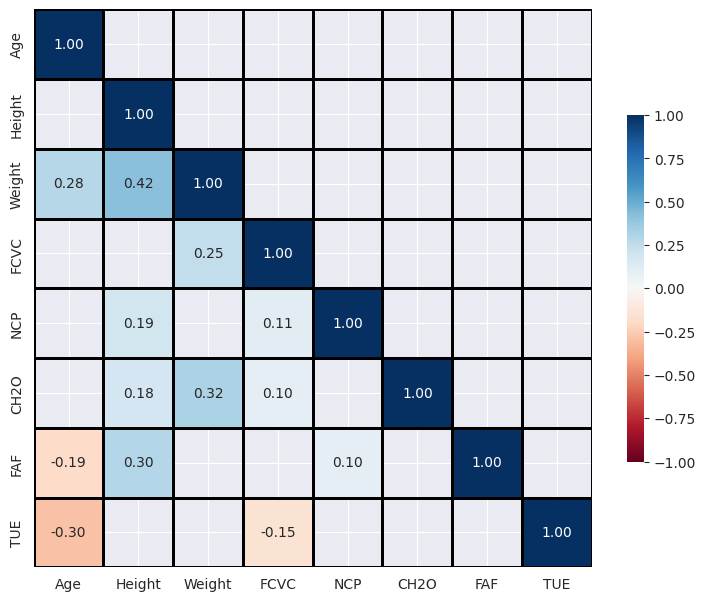

In [34]:
HeatmapPlot(df.iloc[:, 1:].select_dtypes(include='number').corr(), (9, 9), .1)

## 4- Data Pre-Processing

In [37]:
df_copy = df.copy()
df_copy.drop(columns='id', inplace=True)

In [38]:
df_copy = df_copy.infer_objects()
print(df_copy.dtypes)

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object


In [39]:
X = df_copy.iloc[:, :-1]
y = df_copy.iloc[:, -1]
X.shape, y.shape

((20758, 16), (20758,))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y, random_state=42)

In [41]:
type(X_train), X_train.shape

(pandas.core.frame.DataFrame, (18682, 16))

In [42]:
ncols = X_train.select_dtypes(include='number').columns.to_list()
ccols = X_train.select_dtypes(include='object').columns.to_list()
print(ncols, ccols, sep='\n')

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


### **Encoding** Train Dataset

In [52]:
# ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary').set_output(transform='pandas')
# cat_encoded = ohe.fit_transform(X_train[ccols])
# ohe_df = pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out())
# ohe_df.head()
# cat_encoded

In [31]:
# ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')
# cat_encoded = ohe.fit_transform(X_train[ccols])
# ohe_df = pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out())
# ohe_df.head()

In [32]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary').set_output(transform='pandas')
ohe_df = ohe.fit_transform(X_train[ccols])
ohe_df.head(1)

,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
3863,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
X_train_ = pd.concat([X_train[ncols], ohe_df], axis=1)
X_train_.head(2)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
3863,21.282530,1.729045,131.529267,3.0,3.000000,1.242832,1.541072,0.930836,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12030,33.789301,1.756772,107.108190,2.0,2.118153,2.452789,1.979355,0.000000,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [56]:
target_labels = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
                      'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

In [67]:
#### Ordinal Encoder encodes the data based on his order not the provided order
ord_enc = OrdinalEncoder(categories=[target_labels])
# ord_enc = OrdinalEncoder()
y_train_ = ord_enc.fit_transform(y_train.array.reshape(-1, 1))
ord_enc.categories_

[array(['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
        'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
        'Overweight_Level_II'], dtype=object)]

In [68]:
ord_enc.transform(pd.DataFrame(target_labels))

array([[0.],
       [1.],
       [5.],
       [6.],
       [2.],
       [3.],
       [4.]])

In [53]:
#### Label Encoder encodes the data based on his order not the provided order
# label_enc = LabelEncoder()

# y_enc = label_enc.fit_transform(df_copy['NObeyesdad'])
# label_enc.classes_

array(['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
       'Overweight_Level_II'], dtype=object)

### **Encoding** Test Dataset

In [38]:
df_test.dtypes

id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object

In [39]:
test_ohe = ohe.transform(X_test[ccols])
X_test_ = pd.concat([X_test[ncols], test_ohe], axis=1)
X_test_.head(2)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
6365,26.0,1.656504,111.884535,3.0,3.0,2.638896,0.0,0.096576,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
11451,18.0,1.750000,52.000000,2.0,3.0,2.000000,0.0,2.000000,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
y_test_ = ord_enc.transform(y_test.array.reshape(-1, 1))

In [41]:
# TSNE_2D(df_ohe, hue=y_enc, title='Original Data');

In [42]:
df_log = X_train_ + .1
df_log = df_log.apply(np.log)

In [43]:
# log_2d = TSNE_2D(df_log, 50, hue=y_enc, title="Log Transformed")

In [44]:
stand_scaler = StandardScaler().set_output(transform="pandas")
df_stand = stand_scaler.fit_transform(X_train_)

In [45]:
# stand_2d = TSNE_2D(df_stand, 50, hue=y_enc, title="Log Transformed")

In [46]:
robust_scaler = RobustScaler().set_output(transform="pandas")
df_robust = robust_scaler.fit_transform(X_train_)

In [47]:
# stand_2d = TSNE_2D(df_robust, 50, hue=y_enc, title="Log Transformed")

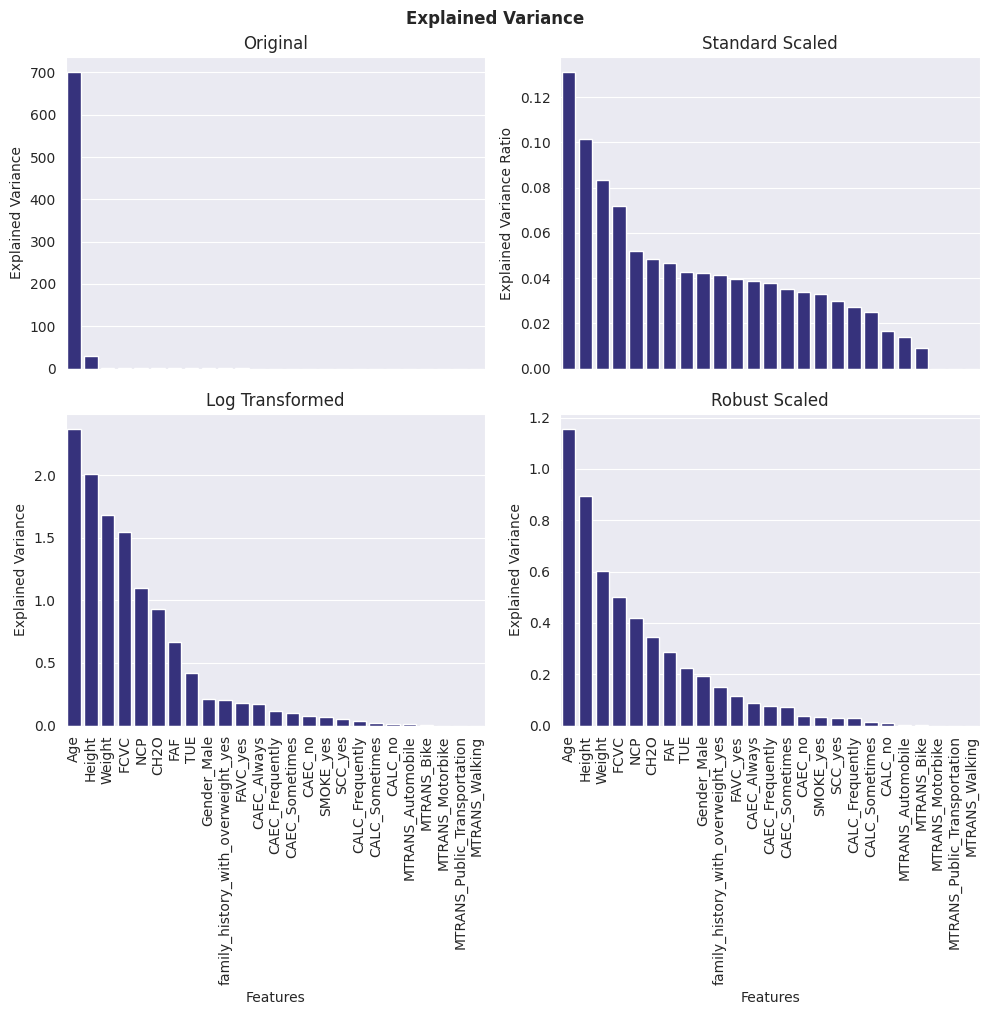

In [48]:
fig, ax = plt.subplots(2, 2, sharex=True)
fig.set_size_inches(10, 10)
plt.sca(ax[0, 0])
ExplainedVarPlot(X_train_)
plt.sca(ax[0, 1])
ExplainedVarPlot(df_stand, 'Standard Scaled', ratio=True)
plt.sca(ax[1, 0])
ExplainedVarPlot(df_log, 'Log Transformed')
plt.sca(ax[1, 1])
ExplainedVarPlot(df_robust, 'Robust Scaled')
plt.tight_layout()
fig.suptitle('Explained Variance', y =1.01, fontweight='bold');

## 5- Models

### 🚀XGBoost
 [Documentaion](https://xgboost.readthedocs.io/en/stable/python/index.html)



In [49]:
xg_clf = xgb.XGBClassifier(n_estimators=200, max_depth=4, n_jobs=-1, seed=42)
xg_clf.fit(X_train_, y_train_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [50]:
y_pred_test = xg_clf.predict(X_test_)
print("🚀Classification Report On Test Dataset")
print(classification_report(y_test_, y_pred_test))

🚀Classification Report On Test Dataset
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       252
         1.0       0.89      0.90      0.90       308
         2.0       0.83      0.77      0.80       243
         3.0       0.80      0.84      0.82       252
         4.0       0.88      0.90      0.89       291
         5.0       0.97      0.97      0.97       325
         6.0       1.00      1.00      1.00       405

    accuracy                           0.91      2076
   macro avg       0.90      0.90      0.90      2076
weighted avg       0.91      0.91      0.91      2076



In [51]:
y_pred_train = xg_clf.predict(X_train_)

print("🚀Classification Report On Train Dataset")
print(classification_report(y_train_, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2271
         1.0       0.94      0.96      0.95      2774
         2.0       0.94      0.90      0.92      2184
         3.0       0.93      0.94      0.94      2270
         4.0       0.97      0.97      0.97      2619
         5.0       1.00      1.00      1.00      2923
         6.0       1.00      1.00      1.00      3641

    accuracy                           0.97     18682
   macro avg       0.97      0.97      0.97     18682
weighted avg       0.97      0.97      0.97     18682



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

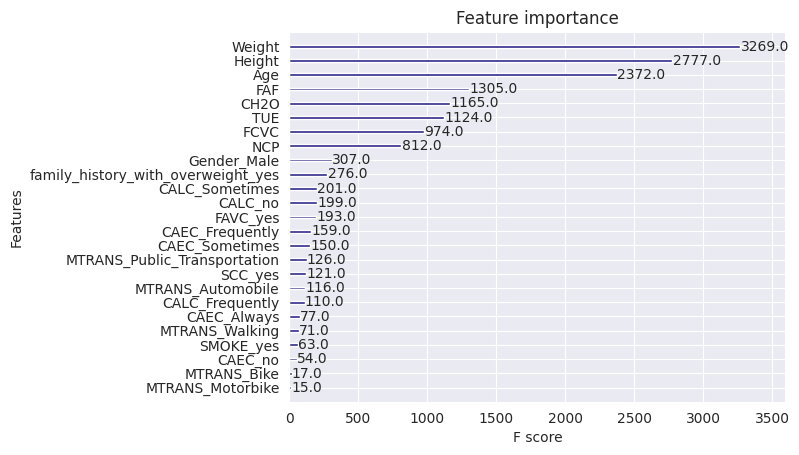

In [63]:
xgb.plot_importance(xg_clf)

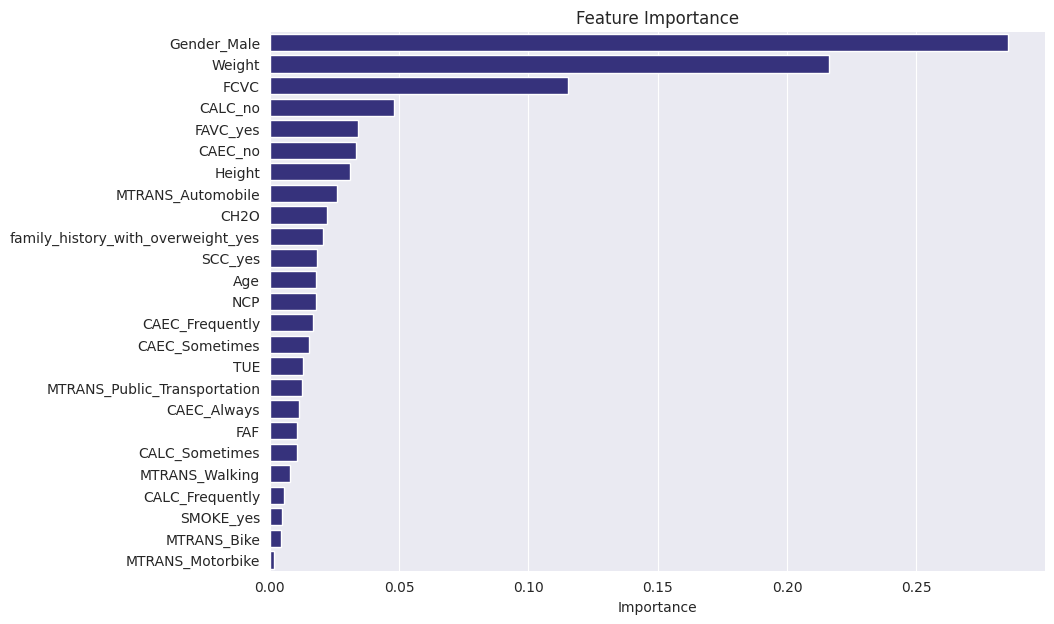

In [72]:
# feature importances
feature_importance = xg_clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train_.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

#### CV


In [88]:
churn_dmatrix = xgb.DMatrix(data=X_train_, label=y_train_)

params={'objective' : 'multi:softmax', "max_depth":12, 'num_class' : y_test.nunique()}
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, nfold=10, stratified =True,
    num_boost_round=10, metrics="merror", as_pandas=True)

print("Accuracy: %f" %((1-cv_results["test-merror-mean"]).iloc[-1]))

Accuracy: 0.898351


#### Tuning

In [211]:
dmatrix = xgb.DMatrix(data=X_train_, label=y_train_)

gbm_param_grid = {'learning_rate': np.arange(0.05, 1.05, .05),
    'n_estimators': [100, 150, 200, 300],
    'subsample': np.arange(0.75,1.05,.05)}

gbm = xgb.XGBClassifier()

randomized_xgb = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid,
        n_iter=25, scoring='accuracy', cv=4, verbose=1)

randomized_xgb.fit(X_train_, y_train_)
print("Best parameters found: ",randomized_xgb.best_params_)
print("Best accuracy found: ", randomized_xgb.best_score_)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
 

Best parameters found:  {'subsample': 1.0000000000000002, 'n_estimators': 300, 'learning_rate': 0.05}
Best accuracy found:  0.9047212698334111


In [212]:
print(randomized_xgb.cv_results_['params'])

[{'subsample': 0.75, 'n_estimators': 100, 'learning_rate': 0.45}, {'subsample': 0.9500000000000002, 'n_estimators': 300, 'learning_rate': 0.6000000000000001}, {'subsample': 0.9000000000000001, 'n_estimators': 100, 'learning_rate': 0.2}, {'subsample': 1.0500000000000003, 'n_estimators': 150, 'learning_rate': 0.55}, {'subsample': 1.0500000000000003, 'n_estimators': 300, 'learning_rate': 0.1}, {'subsample': 0.9500000000000002, 'n_estimators': 100, 'learning_rate': 0.45}, {'subsample': 0.9500000000000002, 'n_estimators': 150, 'learning_rate': 0.2}, {'subsample': 1.0500000000000003, 'n_estimators': 150, 'learning_rate': 0.3}, {'subsample': 0.9000000000000001, 'n_estimators': 300, 'learning_rate': 0.8500000000000001}, {'subsample': 0.75, 'n_estimators': 300, 'learning_rate': 1.0}, {'subsample': 1.0500000000000003, 'n_estimators': 100, 'learning_rate': 0.3}, {'subsample': 0.75, 'n_estimators': 200, 'learning_rate': 0.55}, {'subsample': 1.0500000000000003, 'n_estimators': 100, 'learning_rate':

In [214]:
best_xgb = randomized_xgb.best_estimator_

In [215]:
y_pred_train = randomized_xgb.predict(X_train_)

print("🚀Classification Report On Train Dataset")
print(classification_report(y_train_, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      2271
         1.0       0.94      0.95      0.94      2774
         2.0       0.91      0.87      0.89      2184
         3.0       0.90      0.91      0.91      2270
         4.0       0.95      0.95      0.95      2619
         5.0       0.99      0.99      0.99      2923
         6.0       1.00      1.00      1.00      3641

    accuracy                           0.96     18682
   macro avg       0.95      0.95      0.95     18682
weighted avg       0.96      0.96      0.96     18682



In [216]:
y_pred_test = randomized_xgb.predict(X_test_)
print("🚀Classification Report On Test Dataset")
print(classification_report(y_test_, y_pred_test))

🚀Classification Report On Test Dataset
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       252
         1.0       0.88      0.90      0.89       308
         2.0       0.84      0.78      0.81       243
         3.0       0.82      0.86      0.84       252
         4.0       0.90      0.90      0.90       291
         5.0       0.97      0.97      0.97       325
         6.0       1.00      1.00      1.00       405

    accuracy                           0.92      2076
   macro avg       0.91      0.91      0.91      2076
weighted avg       0.92      0.92      0.92      2076



### 🚀LightGBM

  [Documentaion](https://lightgbm.readthedocs.io/en/stable/index.html)

In [52]:
lbm_clf = lgbm.LGBMClassifier(n_jobs=-1)
lbm_clf.fit(X_train_, y_train_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(n_jobs=-1)

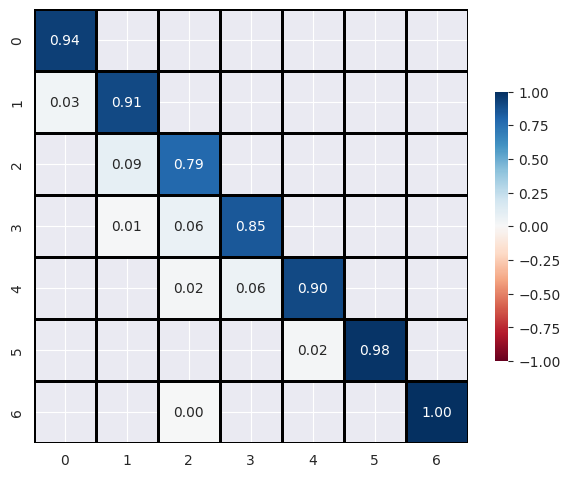

In [165]:
y_pred_test = lbm_clf.predict(X_test_)
conf_matrix = confusion_matrix(y_test_, y_pred_test, normalize='true')

HeatmapPlot(conf_matrix, (7, 7))

In [53]:
y_pred_test = lbm_clf.predict(X_test_)
print("🚀Classification Report On Test Dataset")
print(classification_report(y_test_, y_pred_test))

🚀Classification Report On Test Dataset
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       252
         1.0       0.88      0.91      0.89       308
         2.0       0.83      0.79      0.81       243
         3.0       0.82      0.85      0.84       252
         4.0       0.90      0.90      0.90       291
         5.0       0.97      0.98      0.97       325
         6.0       1.00      1.00      1.00       405

    accuracy                           0.92      2076
   macro avg       0.91      0.91      0.91      2076
weighted avg       0.92      0.92      0.92      2076



In [54]:
y_pred_train = lbm_clf.predict(X_train_)

print("🚀Classification Report On Train Dataset")
print(classification_report(y_train_, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      2271
         1.0       0.96      0.97      0.97      2774
         2.0       0.95      0.92      0.94      2184
         3.0       0.95      0.95      0.95      2270
         4.0       0.98      0.98      0.98      2619
         5.0       1.00      1.00      1.00      2923
         6.0       1.00      1.00      1.00      3641

    accuracy                           0.98     18682
   macro avg       0.97      0.97      0.97     18682
weighted avg       0.98      0.98      0.98     18682



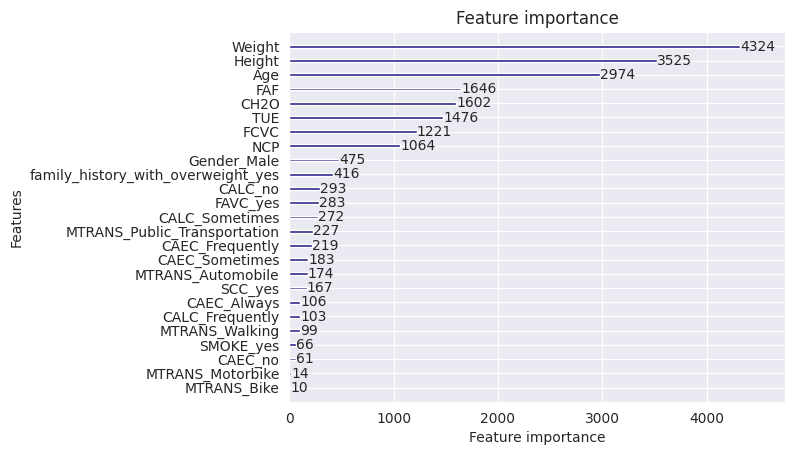

In [55]:
lgbm.plot_importance(lbm_clf);

#### Tuning


In [176]:
import optuna.integration.lightgbm as lgb

from lightgbm import early_stopping
from lightgbm import log_evaluation



if __name__ == "__main__":

    dtrain = lgb.Dataset(X_train_, label=y_train_)
    dval = lgb.Dataset(X_test_, label=y_test_)

    params = {
        "objective": "multiclass",
        "metric": "multi_error",
        # "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 7,
    }

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        callbacks=[early_stopping(100), log_evaluation(100)],
    )


[I 2024-03-13 16:16:42,165] A new study created in memory with name: no-name-f97fb165-d0fb-492c-af21-126f628c1c69

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:300: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0305107	valid_1's multi_error: 0.0780347



feature_fraction, val_score: 0.074663:  14%|#4        | 1/7 [00:05<00:30,  5.13s/it][I 2024-03-13 16:16:47,317] Trial 0 finished with value: 0.07466281310211946 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.07466281310211946.

feature_fraction, val_score: 0.074663:  14%|#4        | 1/7 [00:05<00:30,  5.13s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[84]	valid_0's multi_error: 0.0373086	valid_1's multi_error: 0.0746628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0323841	valid_1's multi_error: 0.0770713
[LightGBM] [Warnin


feature_fraction, val_score: 0.072736:  29%|##8       | 2/7 [00:12<00:31,  6.31s/it][I 2024-03-13 16:16:54,458] Trial 1 finished with value: 0.07273603082851637 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.07273603082851637.

feature_fraction, val_score: 0.072736:  29%|##8       | 2/7 [00:12<00:31,  6.31s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0248367	valid_1's multi_error: 0.0770713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit


feature_fraction, val_score: 0.072736:  43%|####2     | 3/7 [00:18<00:25,  6.30s/it][I 2024-03-13 16:17:00,749] Trial 2 finished with value: 0.07514450867052024 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.07273603082851637.

feature_fraction, val_score: 0.072736:  43%|####2     | 3/7 [00:18<00:25,  6.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0264961	valid_1's multi_error: 0.0765896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit


feature_fraction, val_score: 0.072736:  43%|####2     | 3/7 [00:25<00:25,  6.30s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[113]	valid_0's multi_error: 0.021518	valid_1's multi_error: 0.0761079



feature_fraction, val_score: 0.072736:  57%|#####7    | 4/7 [00:25<00:20,  6.72s/it][I 2024-03-13 16:17:08,098] Trial 3 finished with value: 0.07610789980732177 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.07273603082851637.

feature_fraction, val_score: 0.072736:  57%|#####7    | 4/7 [00:25<00:20,  6.72s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0261749	valid_1's multi_error: 0.0765896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit


feature_fraction, val_score: 0.072736:  71%|#######1  | 5/7 [00:32<00:12,  6.50s/it][I 2024-03-13 16:17:14,207] Trial 4 finished with value: 0.075626204238921 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.07273603082851637.

feature_fraction, val_score: 0.072736:  71%|#######1  | 5/7 [00:32<00:12,  6.50s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0231239	valid_1's multi_error: 0.0823699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b


feature_fraction, val_score: 0.072736:  86%|########5 | 6/7 [00:38<00:06,  6.52s/it][I 2024-03-13 16:17:20,761] Trial 5 finished with value: 0.0804431599229287 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.07273603082851637.

feature_fraction, val_score: 0.072736:  86%|########5 | 6/7 [00:38<00:06,  6.52s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[82]	valid_0's multi_error: 0.0316883	valid_1's multi_error: 0.0804432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Tr


feature_fraction, val_score: 0.072736: 100%|##########| 7/7 [00:43<00:00,  6.26s/it]


Early stopping, best iteration is:
[94]	valid_0's multi_error: 0.0401456	valid_1's multi_error: 0.0761079



num_leaves, val_score: 0.072736:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.00358634	valid_1's multi_error: 0.0799615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi


num_leaves, val_score: 0.072736:   5%|5         | 1/20 [00:10<03:17, 10.40s/it][I 2024-03-13 16:17:36,446] Trial 7 finished with value: 0.07803468208092486 and parameters: {'num_leaves': 93}. Best is trial 7 with value: 0.07803468208092486.

num_leaves, val_score: 0.072736:   5%|5         | 1/20 [00:10<03:17, 10.40s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0333476	valid_1's multi_error: 0.0785164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's multi_error: 0.0110802	valid_1's 


num_leaves, val_score: 0.072736:  10%|#         | 2/20 [00:18<02:37,  8.77s/it][I 2024-03-13 16:17:44,076] Trial 8 finished with value: 0.07466281310211946 and parameters: {'num_leaves': 30}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  10%|#         | 2/20 [00:18<02:37,  8.77s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0168076	valid_1's multi_error: 0.0789981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit


num_leaves, val_score: 0.072736:  15%|#5        | 3/20 [00:23<02:04,  7.33s/it][I 2024-03-13 16:17:49,699] Trial 9 finished with value: 0.07466281310211946 and parameters: {'num_leaves': 48}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  15%|#5        | 3/20 [00:23<02:04,  7.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with po


num_leaves, val_score: 0.072736:  20%|##        | 4/20 [00:40<02:57, 11.10s/it][I 2024-03-13 16:18:06,559] Trial 10 finished with value: 0.07996146435452794 and parameters: {'num_leaves': 247}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  20%|##        | 4/20 [00:40<02:57, 11.10s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with po


num_leaves, val_score: 0.072736:  25%|##5       | 5/20 [00:51<02:46, 11.11s/it][I 2024-03-13 16:18:17,691] Trial 11 finished with value: 0.08140655105973026 and parameters: {'num_leaves': 201}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  25%|##5       | 5/20 [00:51<02:46, 11.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.000695857	valid


num_leaves, val_score: 0.072736:  30%|###       | 6/20 [01:07<02:56, 12.57s/it][I 2024-03-13 16:18:33,113] Trial 12 finished with value: 0.0789980732177264 and parameters: {'num_leaves': 162}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  30%|###       | 6/20 [01:07<02:56, 12.57s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.00176641	valid_1's multi_error: 0.0828516
[LightGBM] [Warning] No further splits with posi


num_leaves, val_score: 0.072736:  30%|###       | 6/20 [01:15<02:56, 12.57s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[51]	valid_0's multi_error: 0.0141312	valid_1's multi_error: 0.0780347



num_leaves, val_score: 0.072736:  35%|###5      | 7/20 [01:15<02:27, 11.36s/it][I 2024-03-13 16:18:41,956] Trial 13 finished with value: 0.07803468208092486 and parameters: {'num_leaves': 121}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  35%|###5      | 7/20 [01:15<02:27, 11.36s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with po


num_leaves, val_score: 0.072736:  40%|####      | 8/20 [01:31<02:30, 12.57s/it][I 2024-03-13 16:18:57,122] Trial 14 finished with value: 0.07851637764932562 and parameters: {'num_leaves': 251}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  40%|####      | 8/20 [01:31<02:30, 12.57s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0963494	valid_1's multi_error: 0.0939306
[200]	valid_0's multi_error: 0.082914	valid_1's multi_error: 0.0833333
[300]	valid_0's multi_error: 0.0758484	valid_1's multi_error: 0.0809249



num_leaves, val_score: 0.072736:  45%|####5     | 9/20 [01:37<01:58, 10.79s/it][I 2024-03-13 16:19:04,003] Trial 15 finished with value: 0.07996146435452794 and parameters: {'num_leaves': 4}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  45%|####5     | 9/20 [01:37<01:58, 10.79s/it]

Early stopping, best iteration is:
[259]	valid_0's multi_error: 0.0781501	valid_1's multi_error: 0.0799615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.00529922	valid_1's multi_error: 0.0794798
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[75]	valid_0's multi_error: 0.011669	valid_1's multi_error: 0.077553


num_leaves, val_score: 0.072736:  50%|#####     | 10/20 [01:45<01:36,  9.66s/it][I 2024-03-13 16:19:11,134] Trial 16 finished with value: 0.07755298651252408 and parameters: {'num_leaves': 81}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  50%|#####     | 10/20 [01:45<01:36,  9.66s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with po


num_leaves, val_score: 0.072736:  55%|#####5    | 11/20 [01:55<01:29,  9.91s/it][I 2024-03-13 16:19:21,618] Trial 17 finished with value: 0.07947976878612717 and parameters: {'num_leaves': 173}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  55%|#####5    | 11/20 [01:55<01:29,  9.91s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with po


num_leaves, val_score: 0.072736:  60%|######    | 12/20 [02:05<01:19,  9.96s/it][I 2024-03-13 16:19:31,691] Trial 18 finished with value: 0.08477842003853564 and parameters: {'num_leaves': 207}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  60%|######    | 12/20 [02:05<01:19,  9.96s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.00128466	valid_1's multi_error: 0.0833333
[LightGBM] [Warning] No further splits with posi


num_leaves, val_score: 0.072736:  65%|######5   | 13/20 [02:14<01:07,  9.65s/it][I 2024-03-13 16:19:40,623] Trial 19 finished with value: 0.07947976878612717 and parameters: {'num_leaves': 134}. Best is trial 8 with value: 0.07466281310211946.

num_leaves, val_score: 0.072736:  65%|######5   | 13/20 [02:14<01:07,  9.65s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0105984	valid_1's multi_error: 0.077553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi


num_leaves, val_score: 0.072736:  70%|#######   | 14/20 [02:20<00:50,  8.42s/it][I 2024-03-13 16:19:46,197] Trial 20 finished with value: 0.07658959537572255 and parameters: {'num_leaves': 62}. Best is trial 8 with value: 0.07466281310211946.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[56]	valid_0's multi_error: 0.0303501	valid_1's multi_error: 0.0765896



num_leaves, val_score: 0.072736:  70%|#######   | 14/20 [02:20<00:50,  8.42s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0852692	valid_1's multi_error: 0.0814066
[200]	valid_0's multi_error: 0.0701745	valid_1's multi_error: 0.0756262
[300]	valid_0's multi_error: 0.0598972	valid_1's multi_error: 0.0765896



num_leaves, val_score: 0.072736:  75%|#######5  | 15/20 [02:27<00:40,  8.01s/it][I 2024-03-13 16:19:53,278] Trial 21 finished with value: 0.07418111753371869 and parameters: {'num_leaves': 6}. Best is trial 21 with value: 0.07418111753371869.

num_leaves, val_score: 0.072736:  75%|#######5  | 15/20 [02:27<00:40,  8.01s/it]

Early stopping, best iteration is:
[229]	valid_0's multi_error: 0.0669093	valid_1's multi_error: 0.0741811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0766513	valid_1's multi_error: 0.0809249
[200]	valid_0's multi_error: 0.0601649	valid_1's multi_error: 0.077553
[300]	valid_0's multi


num_leaves, val_score: 0.072736:  80%|########  | 16/20 [02:33<00:30,  7.52s/it][I 2024-03-13 16:19:59,638] Trial 22 finished with value: 0.07466281310211946 and parameters: {'num_leaves': 8}. Best is trial 21 with value: 0.07418111753371869.

num_leaves, val_score: 0.072736:  80%|########  | 16/20 [02:33<00:30,  7.52s/it]

Early stopping, best iteration is:
[262]	valid_0's multi_error: 0.0510652	valid_1's multi_error: 0.0746628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.00251579	valid_1's multi_error: 0.0828516
[LightGBM] [Warn


num_leaves, val_score: 0.072736:  85%|########5 | 17/20 [02:41<00:23,  7.76s/it][I 2024-03-13 16:20:07,971] Trial 23 finished with value: 0.07803468208092486 and parameters: {'num_leaves': 109}. Best is trial 21 with value: 0.07418111753371869.

num_leaves, val_score: 0.072736:  85%|########5 | 17/20 [02:41<00:23,  7.76s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0261749	valid_1's multi_error: 0.0828516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit


num_leaves, val_score: 0.072736:  90%|######### | 18/20 [02:48<00:14,  7.49s/it][I 2024-03-13 16:20:14,830] Trial 24 finished with value: 0.07755298651252408 and parameters: {'num_leaves': 37}. Best is trial 21 with value: 0.07418111753371869.

num_leaves, val_score: 0.072736:  90%|######### | 18/20 [02:48<00:14,  7.49s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[84]	valid_0's multi_error: 0.0322771	valid_1's multi_error: 0.077553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's 


num_leaves, val_score: 0.072736:  95%|#########5| 19/20 [02:53<00:06,  6.73s/it][I 2024-03-13 16:20:19,780] Trial 25 finished with value: 0.0789980732177264 and parameters: {'num_leaves': 67}. Best is trial 21 with value: 0.07418111753371869.

num_leaves, val_score: 0.072736:  95%|#########5| 19/20 [02:53<00:06,  6.73s/it]

Early stopping, best iteration is:
[35]	valid_0's multi_error: 0.0468365	valid_1's multi_error: 0.0789981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	valid_0's


num_leaves, val_score: 0.072736: 100%|##########| 20/20 [03:03<00:00,  9.19s/it]

bagging, val_score: 0.072736:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.038058	valid_1's multi_error: 0.0823699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



bagging, val_score: 0.072736:  10%|#         | 1/10 [00:04<00:41,  4.62s/it][I 2024-03-13 16:20:34,478] Trial 27 finished with value: 0.0789980732177264 and parameters: {'bagging_fraction': 0.4466589985776839, 'bagging_freq': 5}. Best is trial 27 with value: 0.0789980732177264.

bagging, val_score: 0.072736:  10%|#         | 1/10 [00:04<00:41,  4.62s/it]

Early stopping, best iteration is:
[49]	valid_0's multi_error: 0.0647682	valid_1's multi_error: 0.0789981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0315812	valid_1's multi_error: 0.0799615



bagging, val_score: 0.072736:  10%|#         | 1/10 [00:10<00:41,  4.62s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[47]	valid_0's multi_error: 0.0605931	valid_1's multi_error: 0.0770713


bagging, val_score: 0.072736:  20%|##        | 2/10 [00:10<00:42,  5.25s/it][I 2024-03-13 16:20:40,177] Trial 28 finished with value: 0.07707129094412331 and parameters: {'bagging_fraction': 0.9531429374667408, 'bagging_freq': 1}. Best is trial 28 with value: 0.07707129094412331.

bagging, val_score: 0.072736:  20%|##        | 2/10 [00:10<00:42,  5.25s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0340435	valid_1's multi_error: 0.0799615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



bagging, val_score: 0.072736:  30%|###       | 3/10 [00:16<00:38,  5.46s/it][I 2024-03-13 16:20:45,881] Trial 29 finished with value: 0.07658959537572255 and parameters: {'bagging_fraction': 0.6702094269646444, 'bagging_freq': 7}. Best is trial 29 with value: 0.07658959537572255.

bagging, val_score: 0.072736:  30%|###       | 3/10 [00:16<00:38,  5.46s/it]

Early stopping, best iteration is:
[76]	valid_0's multi_error: 0.0450701	valid_1's multi_error: 0.0765896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0313136	valid_1's multi_error: 0.0780347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin


bagging, val_score: 0.072736:  40%|####      | 4/10 [00:25<00:41,  6.90s/it][I 2024-03-13 16:20:54,982] Trial 30 finished with value: 0.075626204238921 and parameters: {'bagging_fraction': 0.9840981991048545, 'bagging_freq': 1}. Best is trial 30 with value: 0.075626204238921.

bagging, val_score: 0.072736:  40%|####      | 4/10 [00:25<00:41,  6.90s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0386468	valid_1's multi_error: 0.0804432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



bagging, val_score: 0.072736:  50%|#####     | 5/10 [00:32<00:35,  7.10s/it][I 2024-03-13 16:21:02,432] Trial 31 finished with value: 0.07755298651252408 and parameters: {'bagging_fraction': 0.4240607596826778, 'bagging_freq': 4}. Best is trial 30 with value: 0.075626204238921.

bagging, val_score: 0.072736:  50%|#####     | 5/10 [00:32<00:35,  7.10s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[91]	valid_0's multi_error: 0.042822	valid_1's multi_error: 0.077553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's m


bagging, val_score: 0.072736:  60%|######    | 6/10 [00:39<00:27,  6.92s/it][I 2024-03-13 16:21:09,014] Trial 32 finished with value: 0.0789980732177264 and parameters: {'bagging_fraction': 0.7230297008770342, 'bagging_freq': 3}. Best is trial 30 with value: 0.075626204238921.

bagging, val_score: 0.072736:  60%|######    | 6/10 [00:39<00:27,  6.92s/it]

Early stopping, best iteration is:
[99]	valid_0's multi_error: 0.0331335	valid_1's multi_error: 0.0789981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.034204	valid_1's multi_error: 0.0818882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



bagging, val_score: 0.072736:  70%|#######   | 7/10 [00:46<00:20,  6.92s/it][I 2024-03-13 16:21:15,923] Trial 33 finished with value: 0.07851637764932562 and parameters: {'bagging_fraction': 0.7353206184963323, 'bagging_freq': 7}. Best is trial 30 with value: 0.075626204238921.

bagging, val_score: 0.072736:  70%|#######   | 7/10 [00:46<00:20,  6.92s/it]

Early stopping, best iteration is:
[64]	valid_0's multi_error: 0.0518681	valid_1's multi_error: 0.0785164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0344182	valid_1's multi_error: 0.0818882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



bagging, val_score: 0.072736:  80%|########  | 8/10 [00:51<00:13,  6.52s/it][I 2024-03-13 16:21:21,607] Trial 34 finished with value: 0.07851637764932562 and parameters: {'bagging_fraction': 0.5856181112791766, 'bagging_freq': 3}. Best is trial 30 with value: 0.075626204238921.

bagging, val_score: 0.072736:  80%|########  | 8/10 [00:51<00:13,  6.52s/it]

Early stopping, best iteration is:
[74]	valid_0's multi_error: 0.0465689	valid_1's multi_error: 0.0785164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0316347	valid_1's multi_error: 0.077553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



bagging, val_score: 0.072736:  90%|######### | 9/10 [00:59<00:06,  6.84s/it][I 2024-03-13 16:21:29,149] Trial 35 finished with value: 0.07514450867052024 and parameters: {'bagging_fraction': 0.8747563248645005, 'bagging_freq': 5}. Best is trial 35 with value: 0.07514450867052024.

bagging, val_score: 0.072736:  90%|######### | 9/10 [00:59<00:06,  6.84s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_error: 0.0415373	valid_1's multi_error: 0.0751445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0322771	valid_1's multi_error: 0.0794798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin


bagging, val_score: 0.072736: 100%|##########| 10/10 [01:08<00:00,  6.85s/it]

feature_fraction_stage2, val_score: 0.072736:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0342576	valid_1's multi_error: 0.077553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



feature_fraction_stage2, val_score: 0.072736:  17%|#6        | 1/6 [00:05<00:28,  5.72s/it][I 2024-03-13 16:21:44,110] Trial 37 finished with value: 0.07707129094412331 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 0.07707129094412331.

feature_fraction_stage2, val_score: 0.072736:  17%|#6        | 1/6 [00:05<00:28,  5.72s/it]

Early stopping, best iteration is:
[93]	valid_0's multi_error: 0.0367198	valid_1's multi_error: 0.0770713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0359169	valid_1's multi_error: 0.0814066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



feature_fraction_stage2, val_score: 0.072736:  33%|###3      | 2/6 [00:11<00:23,  5.78s/it][I 2024-03-13 16:21:49,936] Trial 38 finished with value: 0.0789980732177264 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 0.07707129094412331.

feature_fraction_stage2, val_score: 0.072736:  33%|###3      | 2/6 [00:11<00:23,  5.78s/it]

Early stopping, best iteration is:
[57]	valid_0's multi_error: 0.0579167	valid_1's multi_error: 0.0789981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0323841	valid_1's multi_error: 0.0770713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin


feature_fraction_stage2, val_score: 0.072736:  50%|#####     | 3/6 [00:17<00:17,  5.76s/it][I 2024-03-13 16:21:55,656] Trial 39 finished with value: 0.07273603082851637 and parameters: {'feature_fraction': 0.516}. Best is trial 39 with value: 0.07273603082851637.

feature_fraction_stage2, val_score: 0.072736:  50%|#####     | 3/6 [00:17<00:17,  5.76s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0310995	valid_1's multi_error: 0.0785164



feature_fraction_stage2, val_score: 0.072736:  67%|######6   | 4/6 [00:23<00:11,  5.90s/it][I 2024-03-13 16:22:01,790] Trial 40 finished with value: 0.07658959537572255 and parameters: {'feature_fraction': 0.58}. Best is trial 39 with value: 0.07273603082851637.

feature_fraction_stage2, val_score: 0.072736:  67%|######6   | 4/6 [00:23<00:11,  5.90s/it]

Early stopping, best iteration is:
[67]	valid_0's multi_error: 0.0461942	valid_1's multi_error: 0.0765896
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0359169	valid_1's multi_error: 0.0814066
[LightGBM] [Warning] No furth


feature_fraction_stage2, val_score: 0.072736:  83%|########3 | 5/6 [00:28<00:05,  5.46s/it][I 2024-03-13 16:22:06,468] Trial 41 finished with value: 0.0789980732177264 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 39 with value: 0.07273603082851637.

feature_fraction_stage2, val_score: 0.072736:  83%|########3 | 5/6 [00:28<00:05,  5.46s/it]

Early stopping, best iteration is:
[57]	valid_0's multi_error: 0.0579167	valid_1's multi_error: 0.0789981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0310995	valid_1's multi_error: 0.0785164



feature_fraction_stage2, val_score: 0.072736: 100%|##########| 6/6 [00:34<00:00,  5.71s/it]


Early stopping, best iteration is:
[67]	valid_0's multi_error: 0.0461942	valid_1's multi_error: 0.0765896



regularization_factors, val_score: 0.072736:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0329729	valid_1's multi_error: 0.0794798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



regularization_factors, val_score: 0.072736:   5%|5         | 1/20 [00:04<01:28,  4.68s/it][I 2024-03-13 16:22:17,331] Trial 43 finished with value: 0.07755298651252408 and parameters: {'lambda_l1': 2.1061791024286858e-05, 'lambda_l2': 0.005736314434469998}. Best is trial 43 with value: 0.07755298651252408.

regularization_factors, val_score: 0.072736:   5%|5         | 1/20 [00:04<01:28,  4.68s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_error: 0.0498876	valid_1's multi_error: 0.077553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li


regularization_factors, val_score: 0.072736:  10%|#         | 2/20 [00:12<01:52,  6.26s/it][I 2024-03-13 16:22:24,699] Trial 44 finished with value: 0.0804431599229287 and parameters: {'lambda_l1': 9.944404298763855, 'lambda_l2': 1.5567471822197502e-08}. Best is trial 43 with value: 0.07755298651252408.

regularization_factors, val_score: 0.072736:  10%|#         | 2/20 [00:12<01:52,  6.26s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 


regularization_factors, val_score: 0.072736:  15%|#5        | 3/20 [00:18<01:44,  6.15s/it][I 2024-03-13 16:22:30,715] Trial 45 finished with value: 0.07803468208092486 and parameters: {'lambda_l1': 7.156379231842002e-08, 'lambda_l2': 7.202739362955528}. Best is trial 43 with value: 0.07755298651252408.

regularization_factors, val_score: 0.072736:  15%|#5        | 3/20 [00:18<01:44,  6.15s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with po


regularization_factors, val_score: 0.072736:  20%|##        | 4/20 [00:25<01:44,  6.53s/it][I 2024-03-13 16:22:37,817] Trial 46 finished with value: 0.07755298651252408 and parameters: {'lambda_l1': 5.389762724651408, 'lambda_l2': 1.3737980144785984e-08}. Best is trial 43 with value: 0.07755298651252408.

regularization_factors, val_score: 0.072736:  20%|##        | 4/20 [00:25<01:44,  6.53s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0321165	valid_1's multi_error: 0.0761079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b


regularization_factors, val_score: 0.072736:  25%|##5       | 5/20 [00:34<01:51,  7.43s/it][I 2024-03-13 16:22:46,839] Trial 47 finished with value: 0.07466281310211946 and parameters: {'lambda_l1': 0.003403594861250302, 'lambda_l2': 0.00042629842155929125}. Best is trial 47 with value: 0.07466281310211946.

regularization_factors, val_score: 0.072736:  25%|##5       | 5/20 [00:34<01:51,  7.43s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with po


regularization_factors, val_score: 0.072736:  30%|###       | 6/20 [00:41<01:43,  7.39s/it][I 2024-03-13 16:22:54,162] Trial 48 finished with value: 0.07803468208092486 and parameters: {'lambda_l1': 1.5937261539706e-08, 'lambda_l2': 6.9816583253903115}. Best is trial 47 with value: 0.07466281310211946.

regularization_factors, val_score: 0.072736:  30%|###       | 6/20 [00:41<01:43,  7.39s/it]

Early stopping, best iteration is:
[131]	valid_0's multi_error: 0.0440531	valid_1's multi_error: 0.0780347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_error: 0.0316347	valid_1's multi_error: 0.0756262
[LightGBM] [Warni


regularization_factors, val_score: 0.072736:  35%|###5      | 7/20 [00:49<01:37,  7.53s/it][I 2024-03-13 16:23:01,985] Trial 49 finished with value: 0.07369942196531792 and parameters: {'lambda_l1': 0.005437888197330666, 'lambda_l2': 5.162799670433302e-06}. Best is trial 49 with value: 0.07369942196531792.

regularization_factors, val_score: 0.072736:  35%|###5      | 7/20 [00:49<01:37,  7.53s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[115]	valid_0's multi_error: 0.0270314	valid_1's multi_error: 0.0736994
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0322771	valid_1's multi_error: 0.0761079
[LightGBM] [Warni


regularization_factors, val_score: 0.072736:  40%|####      | 8/20 [00:54<01:21,  6.80s/it][I 2024-03-13 16:23:07,226] Trial 50 finished with value: 0.07418111753371869 and parameters: {'lambda_l1': 0.003219540829464868, 'lambda_l2': 3.689623618512574e-06}. Best is trial 49 with value: 0.07369942196531792.

regularization_factors, val_score: 0.072736:  40%|####      | 8/20 [00:54<01:21,  6.80s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0322235	valid_1's multi_error: 0.0756262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit


regularization_factors, val_score: 0.072736:  45%|####5     | 9/20 [01:02<01:17,  7.02s/it][I 2024-03-13 16:23:14,737] Trial 51 finished with value: 0.07273603082851637 and parameters: {'lambda_l1': 0.0031658855839042893, 'lambda_l2': 3.1003145588323393e-06}. Best is trial 51 with value: 0.07273603082851637.

regularization_factors, val_score: 0.072736:  45%|####5     | 9/20 [01:02<01:17,  7.02s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[105]	valid_0's multi_error: 0.030136	valid_1's multi_error: 0.072736
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's 


regularization_factors, val_score: 0.072736:  50%|#####     | 10/20 [01:06<01:03,  6.35s/it][I 2024-03-13 16:23:19,578] Trial 52 finished with value: 0.075626204238921 and parameters: {'lambda_l1': 0.008039672692362674, 'lambda_l2': 2.6093072837889566e-06}. Best is trial 51 with value: 0.07273603082851637.

regularization_factors, val_score: 0.072736:  50%|#####     | 10/20 [01:06<01:03,  6.35s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_error: 0.0329194	valid_1


regularization_factors, val_score: 0.072736:  55%|#####5    | 11/20 [01:15<01:04,  7.12s/it][I 2024-03-13 16:23:28,455] Trial 53 finished with value: 0.07321772639691715 and parameters: {'lambda_l1': 0.016937267072546388, 'lambda_l2': 3.3998941513136786e-06}. Best is trial 51 with value: 0.07273603082851637.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[144]	valid_0's multi_error: 0.0198587	valid_1's multi_error: 0.0732177



regularization_factors, val_score: 0.072736:  55%|#####5    | 11/20 [01:15<01:04,  7.12s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po


regularization_factors, val_score: 0.072736:  60%|######    | 12/20 [01:22<00:56,  7.01s/it][I 2024-03-13 16:23:35,212] Trial 54 finished with value: 0.07466281310211946 and parameters: {'lambda_l1': 0.045951705354327195, 'lambda_l2': 2.9724466574787607e-06}. Best is trial 51 with value: 0.07273603082851637.

regularization_factors, val_score: 0.072736:  60%|######    | 12/20 [01:22<00:56,  7.01s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[69]	valid_0's multi_error: 0.0473183	valid_1's multi_error: 0.0746628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's


regularization_factors, val_score: 0.072736:  65%|######5   | 13/20 [01:28<00:45,  6.54s/it][I 2024-03-13 16:23:40,670] Trial 55 finished with value: 0.07610789980732177 and parameters: {'lambda_l1': 5.529433995676052e-05, 'lambda_l2': 2.128528799391661e-05}. Best is trial 51 with value: 0.07273603082851637.

regularization_factors, val_score: 0.072736:  65%|######5   | 13/20 [01:28<00:45,  6.54s/it]

Early stopping, best iteration is:
[87]	valid_0's multi_error: 0.0373622	valid_1's multi_error: 0.0761079
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War


regularization_factors, val_score: 0.072736:  70%|#######   | 14/20 [01:35<00:40,  6.75s/it][I 2024-03-13 16:23:47,893] Trial 56 finished with value: 0.07418111753371869 and parameters: {'lambda_l1': 0.13607822000089947, 'lambda_l2': 9.174395609701884e-05}. Best is trial 51 with value: 0.07273603082851637.

regularization_factors, val_score: 0.072736:  70%|#######   | 14/20 [01:35<00:40,  6.75s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[83]	valid_0's multi_error: 0.0415908	valid_1's multi_error: 0.0741811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0317418	valid_1's multi_error: 0.0765896
[LightGBM] [Warnin


regularization_factors, val_score: 0.072736:  75%|#######5  | 15/20 [01:41<00:33,  6.69s/it][I 2024-03-13 16:23:54,446] Trial 57 finished with value: 0.07321772639691715 and parameters: {'lambda_l1': 0.0002643044040995787, 'lambda_l2': 2.789410818419199e-07}. Best is trial 51 with value: 0.07273603082851637.

regularization_factors, val_score: 0.072736:  75%|#######5  | 15/20 [01:41<00:33,  6.69s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0319024	valid_1's multi_error: 0.0765896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit


regularization_factors, val_score: 0.072736:  80%|########  | 16/20 [01:49<00:27,  6.98s/it][I 2024-03-13 16:24:02,097] Trial 58 finished with value: 0.07466281310211946 and parameters: {'lambda_l1': 0.00028771265589030867, 'lambda_l2': 2.9104668047850615e-07}. Best is trial 51 with value: 0.07273603082851637.

regularization_factors, val_score: 0.072736:  80%|########  | 16/20 [01:49<00:27,  6.98s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0329729	valid_1's multi_error: 0.077553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



regularization_factors, val_score: 0.072736:  85%|########5 | 17/20 [01:54<00:19,  6.40s/it][I 2024-03-13 16:24:07,136] Trial 59 finished with value: 0.07514450867052024 and parameters: {'lambda_l1': 0.00038242129392042525, 'lambda_l2': 4.1634199289003036e-07}. Best is trial 51 with value: 0.07273603082851637.

regularization_factors, val_score: 0.072736:  85%|########5 | 17/20 [01:54<00:19,  6.40s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[77]	valid_0's multi_error: 0.0424473	valid_1's multi_error: 0.0751445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [War


regularization_factors, val_score: 0.072736:  90%|######### | 18/20 [02:00<00:12,  6.41s/it][I 2024-03-13 16:24:13,590] Trial 60 finished with value: 0.07514450867052024 and parameters: {'lambda_l1': 0.11227663495573002, 'lambda_l2': 1.3364576101295837e-07}. Best is trial 51 with value: 0.07273603082851637.

regularization_factors, val_score: 0.072736:  90%|######### | 18/20 [02:00<00:12,  6.41s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[63]	valid_0's multi_error: 0.0514934	valid_1's multi_error: 0.0751445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0317953	valid_1's multi_error: 0.077553
[LightGBM] [Warning


regularization_factors, val_score: 0.072736:  95%|#########5| 19/20 [02:06<00:06,  6.15s/it][I 2024-03-13 16:24:19,142] Trial 61 finished with value: 0.075626204238921 and parameters: {'lambda_l1': 3.6696512251173943e-06, 'lambda_l2': 1.9804047812076952e-05}. Best is trial 51 with value: 0.07273603082851637.

regularization_factors, val_score: 0.072736:  95%|#########5| 19/20 [02:06<00:06,  6.15s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0319024	valid_1's multi_error: 0.077553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi


regularization_factors, val_score: 0.072736: 100%|##########| 20/20 [02:14<00:00,  6.74s/it]

min_child_samples, val_score: 0.072736:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0370945	valid_1's multi_error: 0.0780347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



min_child_samples, val_score: 0.072736:  20%|##        | 1/5 [00:07<00:28,  7.16s/it][I 2024-03-13 16:24:34,680] Trial 63 finished with value: 0.07418111753371869 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.07418111753371869.

min_child_samples, val_score: 0.072736:  20%|##        | 1/5 [00:07<00:28,  7.16s/it]

Early stopping, best iteration is:
[86]	valid_0's multi_error: 0.0431967	valid_1's multi_error: 0.0741811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0294936	valid_1's multi_error: 0.0761079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



min_child_samples, val_score: 0.072736:  40%|####      | 2/5 [00:12<00:17,  5.82s/it][I 2024-03-13 16:24:39,565] Trial 64 finished with value: 0.07466281310211946 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.07418111753371869.

min_child_samples, val_score: 0.072736:  40%|####      | 2/5 [00:12<00:17,  5.82s/it]

Early stopping, best iteration is:
[80]	valid_0's multi_error: 0.0387004	valid_1's multi_error: 0.0746628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0418585	valid_1's multi_error: 0.0765896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



min_child_samples, val_score: 0.072736:  60%|######    | 3/5 [00:18<00:12,  6.23s/it][I 2024-03-13 16:24:46,279] Trial 65 finished with value: 0.07418111753371869 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.07418111753371869.

min_child_samples, val_score: 0.072736:  60%|######    | 3/5 [00:18<00:12,  6.23s/it]

Early stopping, best iteration is:
[80]	valid_0's multi_error: 0.0502623	valid_1's multi_error: 0.0741811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0276737	valid_1's multi_error: 0.0765896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



min_child_samples, val_score: 0.072736:  80%|########  | 4/5 [00:23<00:05,  5.57s/it][I 2024-03-13 16:24:50,848] Trial 66 finished with value: 0.07466281310211946 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.07418111753371869.

min_child_samples, val_score: 0.072736:  80%|########  | 4/5 [00:23<00:05,  5.57s/it]

Early stopping, best iteration is:
[69]	valid_0's multi_error: 0.041912	valid_1's multi_error: 0.0746628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.107340
[LightGBM] [Info] Start training from score -1.907270
[LightGBM] [Info] Start training from score -2.146402
[LightGBM] [Info] Start training from score -2.107781
[LightGBM] [Info] Start training from score -1.964768
[LightGBM] [Info] Start training from score -1.854950
[LightGBM] [Info] Start training from score -1.635302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_error: 0.0329194	valid_1's multi_error: 0.0751445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



min_child_samples, val_score: 0.072736: 100%|##########| 5/5 [00:30<00:00,  6.02s/it]

Early stopping, best iteration is:
[88]	valid_0's multi_error: 0.0380045	valid_1's multi_error: 0.0741811


In [189]:
    prediction = model.predict(X_test_, num_iteration=model.best_iteration).argmax(axis=1)
    print(prediction.shape, prediction)
    accuracy = classification_report(y_test_, prediction)

    best_params = model.params
    print("Best params:", best_params)
    print("  Accuracy = {}".format(accuracy))
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

(2076,) [6 0 4 ... 6 5 1]
Best params: {'objective': 'multiclass', 'metric': 'multi_error', 'boosting_type': 'gbdt', 'random_state': 42, 'num_class': 7, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000}
  Accuracy =               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       252
         1.0       0.90      0.91      0.90       308
         2.0       0.87      0.81      0.84       243
         3.0       0.84      0.87      0.85       252
         4.0       0.91      0.92      0.91       291
         5.0       0.97      0.98      0.97       325
         6.0       1.00      1.00      1.00       405

    accuracy                           0.93      2076
   macro avg       0.92      0.92      0.92      2076
weighted avg       0.93      0.93      0.93      2076

  Params: 
    objective: multiclass

In [193]:
best_params = {'objective': 'multiclass', 'metric': 'multi_error',
              'boosting_type': 'gbdt', 'random_state': 42, 'num_class': 7,
              'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0,
              'num_leaves': 31, 'feature_fraction': 0.5, 'bagging_fraction': 1.0,
              'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000
              }

best_lgb = lgbm.LGBMClassifier(**best_params, n_jobs=-1)

In [194]:
best_lgb.fit(X_train_, y_train_)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[Ligh

LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.5,
               feature_pre_filter=False, lambda_l1=0.0, lambda_l2=0.0,
               metric='multi_error', n_jobs=-1, num_class=7,
               num_iterations=1000, objective='multiclass', random_state=42)

In [195]:
y_pred_test = best_lgb.predict(X_test_)
print("🚀Classification Report On Test Dataset")
print(classification_report(y_test_, y_pred_test))

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
🚀Classification Report On Test Dataset
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       252
         1.0       0.87      0.89      0.88       308
         2.0       0.82      0.77      0.80       243
         3.0       0.82      0.83      0.82       252
         4.0       0.89      0.91      0.90       291
         5.0       0.98      0.98      0.98       325
         6.0       1.00   

In [196]:
y_pred_train = best_lgb.predict(X_train_)

print("🚀Classification Report On Train Dataset")
print(classification_report(y_train_, y_pred_train))

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2271
         1.0       1.00      1.00      1.00      2774
         2.0       1.00      1.00      1.00      2184
         3.0       1.00      1.00      1.00      2270
         4.0       1.00      1.00      1.00      2619
         5.0       1.00      1.00      1.00      2923
         6.0       1.00  

### 🚀CatBoost

[Documentation](https://catboost.ai/)

In [228]:
cat_clf = cb.CatBoostClassifier(verbose=0)
cat_clf.fit(X_train_, y_train_)

In [229]:
y_pred_test = cat_clf.predict(X_test_)
print("🚀Classification Report On Test Dataset")
print(classification_report(y_test_, y_pred_test))

🚀Classification Report On Test Dataset
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       252
         1.0       0.88      0.90      0.89       308
         2.0       0.85      0.77      0.81       243
         3.0       0.80      0.85      0.83       252
         4.0       0.89      0.91      0.90       291
         5.0       0.97      0.97      0.97       325
         6.0       1.00      1.00      1.00       405

    accuracy                           0.91      2076
   macro avg       0.91      0.90      0.90      2076
weighted avg       0.91      0.91      0.91      2076



In [230]:
y_pred_train = cat_clf.predict(X_train_)

print("🚀Classification Report On Train Dataset")
print(classification_report(y_train_, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2271
         1.0       0.94      0.95      0.95      2774
         2.0       0.92      0.88      0.90      2184
         3.0       0.91      0.92      0.91      2270
         4.0       0.95      0.94      0.95      2619
         5.0       0.98      0.99      0.98      2923
         6.0       1.00      1.00      1.00      3641

    accuracy                           0.96     18682
   macro avg       0.95      0.95      0.95     18682
weighted avg       0.96      0.96      0.96     18682



### Voting

In [241]:
estimators = [('xgb' , xg_clf),
                ('lgb', lbm_clf),
                # ('cb', cat_clf),
                ('lr', LogisticRegression()),
                ('rf', RandomForestClassifier())
                ]
v_clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

v_clf.fit(X_train_, y_train_)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('lgb', LGBMClassifier(n_jobs=-1)),
                             ('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier())],
                 n_jobs=-1, voting='soft')

In [243]:
y_pred_train = v_clf.predict(X_train_)

print("🚀Classification Report On Train Dataset")
print(classification_report(y_train_, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2271
         1.0       0.97      0.97      0.97      2774
         2.0       0.96      0.95      0.95      2184
         3.0       0.97      0.96      0.97      2270
         4.0       0.98      0.98      0.98      2619
         5.0       1.00      1.00      1.00      2923
         6.0       1.00      1.00      1.00      3641

    accuracy                           0.98     18682
   macro avg       0.98      0.98      0.98     18682
weighted avg       0.98      0.98      0.98     18682



In [244]:
y_pred_test = v_clf.predict(X_test_)
print("🚀Classification Report On Test Dataset")
print(classification_report(y_test_, y_pred_test))

🚀Classification Report On Test Dataset
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       252
         1.0       0.88      0.90      0.89       308
         2.0       0.83      0.76      0.79       243
         3.0       0.82      0.85      0.83       252
         4.0       0.89      0.89      0.89       291
         5.0       0.96      0.98      0.97       325
         6.0       1.00      1.00      1.00       405

    accuracy                           0.91      2076
   macro avg       0.91      0.90      0.90      2076
weighted avg       0.91      0.91      0.91      2076



### Stacking



In [246]:
estimators = [('xgb' , xg_clf),
                ('lgb', lbm_clf),
                # ('cb', cat_clf),
                ('lr', LogisticRegression()),
                ('rf', RandomForestClassifier())
                ]
v_clf = StackingClassifier(estimators=estimators, final_estimator=best_lgb,
                         cv=StratifiedKFold(5, shuffle=True, random_state=42), n_jobs=-1)

v_clf.fit(X_train_, y_train_)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[Ligh

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None...
                                              objective='multi:softprob', ...)),
                               ('lgb', LGBMClassifier(n_jobs=-1)),
                               ('lr', LogisticRegression()),
                               ('rf', RandomForestClassifier())],
                   final_estimator=LGBMClassifier(bagging_fraction=1.0,
                                                  bagging_freq=0,
                                                  feature_fraction=0.5,
                                                  feature_pre_filter=False,
                                                  lambda_l1=0.0, lambda_l2=0.0,
                                                  metric='multi_error',
                                                  n_jobs=-1, num_class=7,
                                                  num_iterations=1000,
                                                  objective='multiclass',
                                                  random_state=42),
                   n_jobs=-1)

In [247]:
y_pred_test = cat_clf.predict(X_test_)
print("🚀Classification Report On Test Dataset")
print(classification_report(y_test_, y_pred_test))

🚀Classification Report On Test Dataset
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       252
         1.0       0.88      0.90      0.89       308
         2.0       0.85      0.77      0.81       243
         3.0       0.80      0.85      0.83       252
         4.0       0.89      0.91      0.90       291
         5.0       0.97      0.97      0.97       325
         6.0       1.00      1.00      1.00       405

    accuracy                           0.91      2076
   macro avg       0.91      0.90      0.90      2076
weighted avg       0.91      0.91      0.91      2076



In [248]:
y_pred_train = cat_clf.predict(X_train_)

print("🚀Classification Report On Train Dataset")
print(classification_report(y_train_, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2271
         1.0       0.94      0.95      0.95      2774
         2.0       0.92      0.88      0.90      2184
         3.0       0.91      0.92      0.91      2270
         4.0       0.95      0.94      0.95      2619
         5.0       0.98      0.99      0.98      2923
         6.0       1.00      1.00      1.00      3641

    accuracy                           0.96     18682
   macro avg       0.95      0.95      0.95     18682
weighted avg       0.96      0.96      0.96     18682

